# Interactive single compartment HH example

To run this interactive Jupyter Notebook, please click on the rocket icon 🚀 in the top panel. For more information, please see {ref}`how to use this documentation <userdocs:usage:jupyterbooks>`. Please uncomment the line below if you use the Google Colab. (It does not include these packages by default).

In [1]:
#%pip install pyneuroml neuromllite NEURON

In [1]:
import math
from neuroml import NeuroMLDocument
from neuroml import Cell
from neuroml import IonChannelHH
from neuroml import GateHHRates
from neuroml import BiophysicalProperties
from neuroml import MembraneProperties
from neuroml import ChannelDensity
from neuroml import HHRate
from neuroml import SpikeThresh
from neuroml import SpecificCapacitance
from neuroml import InitMembPotential
from neuroml import IntracellularProperties
from neuroml import IncludeType
from neuroml import Resistivity
from neuroml import Morphology, Segment, Point3DWithDiam
from neuroml import Network, Population
from neuroml import PulseGenerator, ExplicitInput
import numpy as np
from pyneuroml import pynml
from pyneuroml.lems import LEMSSimulation

## Declare the model
### Create ion channels

In [2]:
def create_na_channel():
    """Create the Na channel.

    This will create the Na channel and save it to a file.
    It will also validate this file.

    returns: name of the created file
    """
    na_channel = IonChannelHH(id="na_channel", notes="Sodium channel for HH cell", conductance="10pS", species="na")
    gate_m = GateHHRates(id="m", instances="3", notes="m gate for na channel")

    m_forward_rate = HHRate(type="HHExpLinearRate", rate="1per_ms", midpoint="-40mV", scale="10mV")
    m_reverse_rate = HHRate(type="HHExpRate", rate="4per_ms", midpoint="-65mV", scale="-18mV")
    gate_m.forward_rate = m_forward_rate
    gate_m.reverse_rate = m_reverse_rate
    na_channel.gate_hh_rates.append(gate_m)

    gate_h = GateHHRates(id="h", instances="1", notes="h gate for na channel")
    h_forward_rate = HHRate(type="HHExpRate", rate="0.07per_ms", midpoint="-65mV", scale="-20mV")
    h_reverse_rate = HHRate(type="HHSigmoidRate", rate="1per_ms", midpoint="-35mV", scale="10mV")
    gate_h.forward_rate = h_forward_rate
    gate_h.reverse_rate = h_reverse_rate
    na_channel.gate_hh_rates.append(gate_h)

    na_channel_doc = NeuroMLDocument(id="na_channel", notes="Na channel for HH neuron")
    na_channel_fn = "HH_example_na_channel.nml"
    na_channel_doc.ion_channel_hhs.append(na_channel)

    pynml.write_neuroml2_file(nml2_doc=na_channel_doc, nml2_file_name=na_channel_fn, validate=True)

    return na_channel_fn

In [3]:
def create_k_channel():
    """Create the K channel

    This will create the K channel and save it to a file.
    It will also validate this file.

    :returns: name of the K channel file
    """
    k_channel = IonChannelHH(id="k_channel", notes="Potassium channel for HH cell", conductance="10pS", species="k")
    gate_n = GateHHRates(id="n", instances="4", notes="n gate for k channel")
    n_forward_rate = HHRate(type="HHExpLinearRate", rate="0.1per_ms", midpoint="-55mV", scale="10mV")
    n_reverse_rate = HHRate(type="HHExpRate", rate="0.125per_ms", midpoint="-65mV", scale="-80mV")
    gate_n.forward_rate = n_forward_rate
    gate_n.reverse_rate = n_reverse_rate
    k_channel.gate_hh_rates.append(gate_n)

    k_channel_doc = NeuroMLDocument(id="k_channel", notes="k channel for HH neuron")
    k_channel_fn = "HH_example_k_channel.nml"
    k_channel_doc.ion_channel_hhs.append(k_channel)

    pynml.write_neuroml2_file(nml2_doc=k_channel_doc, nml2_file_name=k_channel_fn, validate=True)

    return k_channel_fn

In [4]:
def create_leak_channel():
    """Create a leak channel

    This will create the leak channel and save it to a file.
    It will also validate this file.

    :returns: name of leak channel nml file
    """
    leak_channel = IonChannelHH(id="leak_channel", conductance="10pS", notes="Leak conductance")
    leak_channel_doc = NeuroMLDocument(id="leak_channel", notes="leak channel for HH neuron")
    leak_channel_fn = "HH_example_leak_channel.nml"
    leak_channel_doc.ion_channel_hhs.append(leak_channel)

    pynml.write_neuroml2_file(nml2_doc=leak_channel_doc, nml2_file_name=leak_channel_fn, validate=True)

    return leak_channel_fn

### Create cell

In [5]:
def create_cell():
    """Create the cell.

    :returns: name of the cell nml file
    """
    # Create the nml file and add the ion channels
    hh_cell_doc = NeuroMLDocument(id="cell", notes="HH cell")
    hh_cell_fn = "HH_example_cell.nml"
    hh_cell_doc.includes.append(IncludeType(href=create_na_channel()))
    hh_cell_doc.includes.append(IncludeType(href=create_k_channel()))
    hh_cell_doc.includes.append(IncludeType(href=create_leak_channel()))

    # Define a cell
    hh_cell = Cell(id="hh_cell", notes="A single compartment HH cell")

    # Define its biophysical properties
    bio_prop = BiophysicalProperties(id="hh_b_prop")
    #  notes="Biophysical properties for HH cell")

    # Membrane properties are a type of biophysical properties
    mem_prop = MembraneProperties()
    # Add membrane properties to the biophysical properties
    bio_prop.membrane_properties = mem_prop

    # Append to cell
    hh_cell.biophysical_properties = bio_prop

    # Channel density for Na channel
    na_channel_density = ChannelDensity(id="na_channels", cond_density="120.0 mS_per_cm2", erev="50.0 mV", ion="na", ion_channel="na_channel")
    mem_prop.channel_densities.append(na_channel_density)

    # Channel density for k channel
    k_channel_density = ChannelDensity(id="k_channels", cond_density="360 S_per_m2", erev="-77mV", ion="k", ion_channel="k_channel")
    mem_prop.channel_densities.append(k_channel_density)

    # Leak channel
    leak_channel_density = ChannelDensity(id="leak_channels", cond_density="3.0 S_per_m2", erev="-54.3mV", ion="non_specific", ion_channel="leak_channel")
    mem_prop.channel_densities.append(leak_channel_density)

    # Other membrane properties
    mem_prop.spike_threshes.append(SpikeThresh(value="-20mV"))
    mem_prop.specific_capacitances.append(SpecificCapacitance(value="1.0 uF_per_cm2"))
    mem_prop.init_memb_potentials.append(InitMembPotential(value="-65mV"))

    intra_prop = IntracellularProperties()
    intra_prop.resistivities.append(Resistivity(value="0.03 kohm_cm"))

    # Add to biological properties
    bio_prop.intracellular_properties = intra_prop

    # Morphology
    morph = Morphology(id="hh_cell_morph")
    #  notes="Simple morphology for the HH cell")
    seg = Segment(id="0", name="soma", notes="Soma segment")
    # We want a diameter such that area is 1000 micro meter^2
    # surface area of a sphere is 4pi r^2 = 4pi diam^2
    diam = math.sqrt(1000 / math.pi)
    proximal = distal = Point3DWithDiam(x="0", y="0", z="0", diameter=str(diam))
    seg.proximal = proximal
    seg.distal = distal
    morph.segments.append(seg)
    hh_cell.morphology = morph

    hh_cell_doc.cells.append(hh_cell)
    pynml.write_neuroml2_file(nml2_doc=hh_cell_doc, nml2_file_name=hh_cell_fn, validate=True)
    return hh_cell_fn

### Create a network

In [6]:
def create_network():
    """Create the network

    :returns: name of network nml file
    """
    net_doc = NeuroMLDocument(id="network",
                              notes="HH cell network")
    net_doc_fn = "HH_example_net.nml"
    net_doc.includes.append(IncludeType(href=create_cell()))
    # Create a population: convenient to create many cells of the same type
    pop = Population(id="pop0", notes="A population for our cell", component="hh_cell", size=1)
    # Input
    pulsegen = PulseGenerator(id="pg", notes="Simple pulse generator", delay="100ms", duration="100ms", amplitude="0.08nA")

    exp_input = ExplicitInput(target="pop0[0]", input="pg")

    net = Network(id="single_hh_cell_network", note="A network with a single population")
    net_doc.pulse_generators.append(pulsegen)
    net.explicit_inputs.append(exp_input)
    net.populations.append(pop)
    net_doc.networks.append(net)

    pynml.write_neuroml2_file(nml2_doc=net_doc, nml2_file_name=net_doc_fn, validate=True)
    return net_doc_fn

## Plot the data we record

In [7]:
def plot_data(sim_id):
    """Plot the sim data.

    Load the data from the file and plot the graph for the membrane potential
    using the pynml generate_plot utility function.

    :sim_id: ID of simulaton

    """
    data_array = np.loadtxt(sim_id + ".dat")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 1]], "Membrane potential", show_plot_already=False, save_figure_to=sim_id + "-v.png", xaxis="time (s)", yaxis="membrane potential (V)")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 2]], "channel current", show_plot_already=False, save_figure_to=sim_id + "-i.png", xaxis="time (s)", yaxis="channel current (A)")
    pynml.generate_plot([data_array[:, 0], data_array[:, 0]], [data_array[:, 3], data_array[:, 4]], "current density", labels=["Na", "K"], show_plot_already=False, save_figure_to=sim_id + "-iden.png", xaxis="time (s)", yaxis="current density (A_per_m2)")

## Create and run the simulation

Create the simulation, run it, record data, and plot the recorded information.

In [8]:
def main():
    """Main function

    Include the NeuroML model into a LEMS simulation file, run it, plot some
    data.
    """
    # Simulation bits
    sim_id = "HH_single_compartment_example_sim"
    simulation = LEMSSimulation(sim_id=sim_id, duration=300, dt=0.01, simulation_seed=123)
    # Include the NeuroML model file
    simulation.include_neuroml2_file(create_network())
    # Assign target for the simulation
    simulation.assign_simulation_target("single_hh_cell_network")

    # Recording information from the simulation
    simulation.create_output_file(id="output0", file_name=sim_id + ".dat")
    simulation.add_column_to_output_file("output0", column_id="pop0[0]/v", quantity="pop0[0]/v")
    simulation.add_column_to_output_file("output0", column_id="pop0[0]/iChannels", quantity="pop0[0]/iChannels")
    simulation.add_column_to_output_file("output0", column_id="pop0[0]/na/iDensity", quantity="pop0[0]/hh_b_prop/membraneProperties/na_channels/iDensity/")
    simulation.add_column_to_output_file("output0", column_id="pop0[0]/k/iDensity", quantity="pop0[0]/hh_b_prop/membraneProperties/k_channels/iDensity/")

    # Save LEMS simulation to file
    sim_file = simulation.save_to_file()

    # Run the simulation using the default jNeuroML simulator
    pynml.run_lems_with_jneuroml(sim_file, max_memory="2G", nogui=True, plot=False)
    # Plot the data
    plot_data(sim_id)

pyNeuroML >>> Written LEMS Simulation HH_single_compartment_example_sim to file: LEMS_HH_single_compartment_example_sim.xml
pyNeuroML >>> Generating plot: Membrane potential


/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1688: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1727: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(xvalues[i], yvalues[i], 'o', marker=marker, markersize=markersize, linestyle=linestyle, linewidth=linewidth, label=label)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1688: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1727

pyNeuroML >>> Saved image to HH_single_compartment_example_sim-v.png of plot: Membrane potential
pyNeuroML >>> Generating plot: channel current
pyNeuroML >>> Saved image to HH_single_compartment_example_sim-i.png of plot: channel current
pyNeuroML >>> Generating plot: current density
pyNeuroML >>> Saved image to HH_single_compartment_example_sim-iden.png of plot: current density


/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1688: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1727: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(xvalues[i], yvalues[i], 'o', marker=marker, markersize=markersize, linestyle=linestyle, linewidth=linewidth, label=label)
/usr/lib/python3.9/site-packages/pyneuroml/pynml.py:1727: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(xvalues[i], yvalues[i], 'o', marker=marker, markersize=markersize, linestyle=linestyle, linewidth=linewidth, label=label)


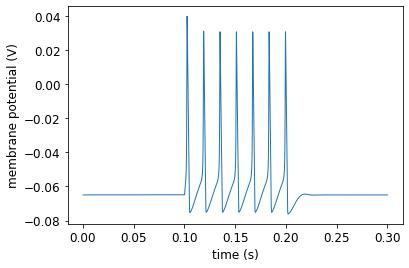

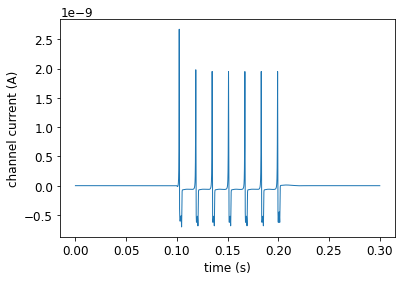

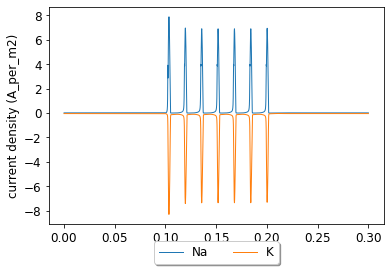

In [9]:
if __name__ == "__main__":
    main()